# 1. Visualization of Spike Data

神経細胞はスパイクと呼ばれる活動電位によって互いに情報を交換する．神経細胞集団の電気活動を分析する上で中心となるのはスパイク時刻の情報である．多電極アレイでは，各電極についてスパイク時刻の列 (spike train) が取得されるが，本章ではそのようなデータの可視化方法について述べる．  

Neurons exchange information with each other by means of action potentials called spikes. Spike times are central to the analysis of the electrical activity of a neuronal population. In a multi-electrode array, a sequence of spike times is obtained for each electrode, and this chapter describes how to visualize such data.

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20
plt.rcParams['figure.dpi'] = 140

In [2]:
datadir = '../datasets/'
df_map = pd.read_csv(datadir + 'mapping.csv', index_col=0)
df_sp = pd.read_csv(datadir + 'spikes.csv', index_col=0)

`df_map`は各電極の情報（x, y座標）を格納し，`df_sp`は各スパイクの情報（検知された電極，検知された時刻）を格納する．  

`df_map` stores each electrode's information (x, y), and `df_sp` stores information on the electrode and time when each spike was detected.

In [3]:
display(df_map.head())
display(df_sp.head())

,channel,x,y
0,0,875.0,1505.0
1,1,3132.5,1242.5
2,2,647.5,1417.5
3,3,2870.0,1032.5
4,4,700.0,682.5


,channel,amplitude,spiketime
0,342,18.561750,0.00000
1,382,22.953043,0.00005
2,708,36.348030,0.09220
3,824,42.317764,0.09220
4,852,46.456272,0.09225


## 1.1. Raster Plot

スパイク時系列 (spike train) は, スパイク時刻と発生電極を両軸に取ったグラフ（ラスタープロットと呼ばれる）により可視化できる.  
 
The spike train can be visualized as a figure with the spike time and the generating electrode on both axes, which is called a raster plot.

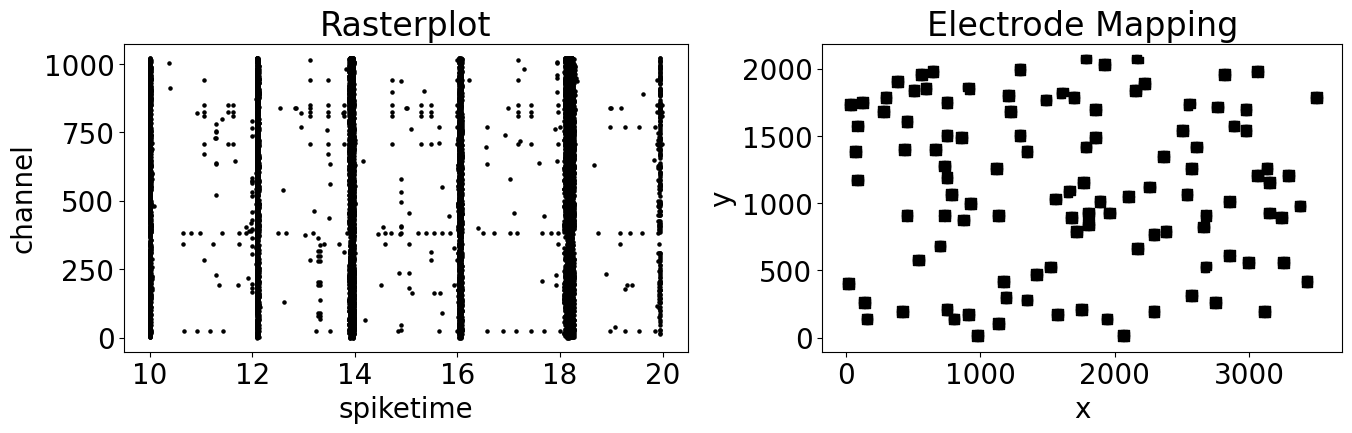

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# rasterplot
df_sp.query('10 < spiketime < 20').plot.scatter(ax=ax1, x='spiketime', y='channel', c='k', s=5)
ax1.set_title('Rasterplot')

# visualize electrode mapping
df_map.plot.scatter(ax=ax2, x='x', y='y', marker='s', c='k')
ax2.set_title('Electrode Mapping')
ax2.set_aspect('equal')

plt.show()

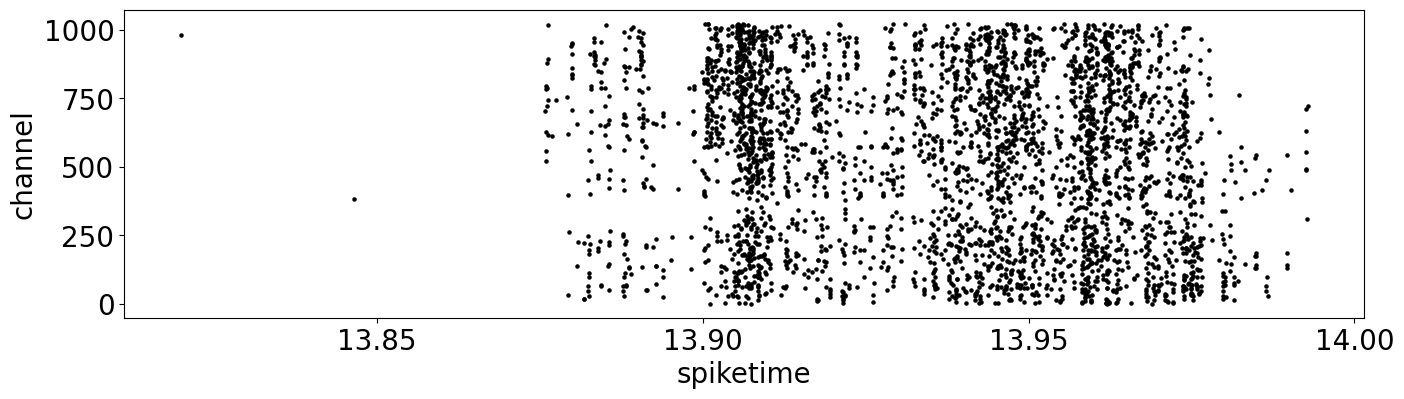

In [62]:
fig, ax = plt.subplots(figsize=(16, 4))
df_sp.query('13.8 < spiketime < 14.0').plot.scatter(ax=ax, x='spiketime', y='channel', c='k', s=5)

plt.locator_params(axis='x', nbins=4)
plt.show()

## 1.2. Global Firing Rate

電極全体での発火頻度（global firing rate）の時間的な推移を，ラスタープロットに重ねて表示したいので，発火時刻についてヒストグラムをとる．

```{tip}
発火頻度のヒストグラムは，ガウシアンフィルタ等によって平滑化すると，細かな変動による影響を緩和できて扱いやすくなる．のちに刺激に対する応答をみる際や，同期バースト検知の際にも有効である．
```

In [67]:
from scipy.ndimage import gaussian_filter

def rasterplot(ax: plt.Axes, df: pd.DataFrame, start: float, end: float, x: str='spiketime', y: str='channel', **kwargs):
    df_ = df.query(f'{start} < {x} < {end}')
    return ax.scatter(x=df_[x], y=df_[y], **kwargs)

def spikehist(ax: plt.Axes, df: pd.DataFrame, start: float, end: float, bin_width: float, x: str='spiketime', y: str='channel', smooth=True, **kwargs):
    df_ = df.query(f'{start} < {x} < {end}')
    hist, edges = np.histogram(df_[x], range=(start, end), bins=int((end-start)/bin_width))
    if smooth: hist = gaussian_filter(hist, sigma=[2])  # smoothing with gaussian filter
    return ax .plot(edges[1:], hist, **kwargs)

def rastergram(ax1: plt.Axes, ax2: plt.Axes, df: pd.DataFrame, start: float, end: float, 
               bin_width: float=0.01, x: str='spiketime', y: str='channel', smooth: bool=True):
    p1 = spikehist(ax1, df, start, end, bin_width, x, y, smooth, linewidth=2.0, c='k')
    p2 = rasterplot(ax2, df, start, end, x, y, c='k', s=5)
    return p1, p2

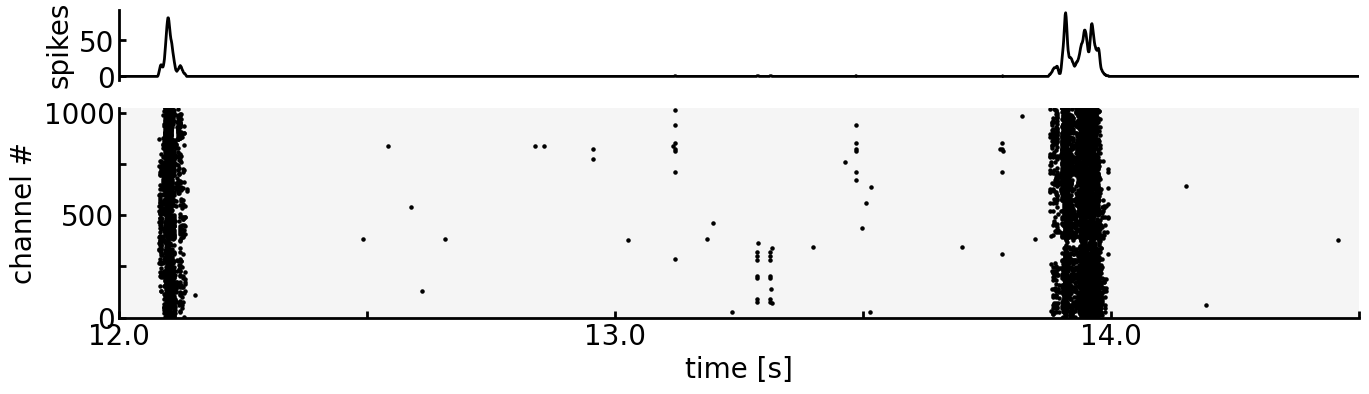

In [66]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 4), gridspec_kw={'height_ratios': [1, 3]})
start, end = 12.0, 14.5
rastergram(ax1=ax1, ax2=ax2, df=df_sp, start=start, end=end, bin_width=0.001)

# optional: touch up the figure layout
ax1.set_xlim(start, end)
ax1.set_xticks([])
ax1.set_ylabel('spikes')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_linewidth(2)
ax1.tick_params(width=2.0, length=5.0, direction='in')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)

ax2.set_xlim(start, end)
ax2.set_xlabel('time [s]')

for i, tick in enumerate(ax2.xaxis.get_ticklabels()):
    if i % 2 != 0:
        tick.set_visible(False) 

ax2.set_ylim(0, 1024)
ax2.set_ylabel('channel #')
ax2.set_yticks([0, 250, 500, 750, 1000])
for i, tick in enumerate(ax2.yaxis.get_ticklabels()):
    if i % 2 != 0:
        tick.set_visible(False) 

ax2.set_facecolor('whitesmoke')
ax2.tick_params(width=2.0, length=5.0, direction='in')

plt.subplots_adjust(hspace=0.2)
plt.show()

## 1.3. Electrode Mapping

次に，MEA上の各電極について神経活動に関する統計量（発火率，平均振幅）を取得し，ヒートマップにより可視化する．

In [11]:
def channel_stats(df_sp: pd.DataFrame, df_map: pd.DataFrame):
    duration = df_sp.spiketime.max() - df_sp.spiketime.min()
    groups = df_sp[['channel', 'amplitude']].groupby('channel')
    
    df_fr = pd.DataFrame(groups.size() / duration, columns=['firing_rate'])  # firing rate for each channel
    df_amp = groups.mean()  # mean spike amplitude for each channel
    
    df_stat = pd.concat([df_map.set_index('channel'), df_fr, df_amp], axis=1, join='inner')
    return df_stat

In [12]:
df_stat = channel_stats(df_sp, df_map)
display(df_stat.head())

,x,y,firing_rate,amplitude
channel,,,,
0,875.0,1505.0,2.303333,68.872199
1,3132.5,1242.5,0.976667,153.558120
2,647.5,1417.5,2.800000,332.676633
3,2870.0,1032.5,0.450000,37.887843
4,700.0,682.5,1.723333,299.170993


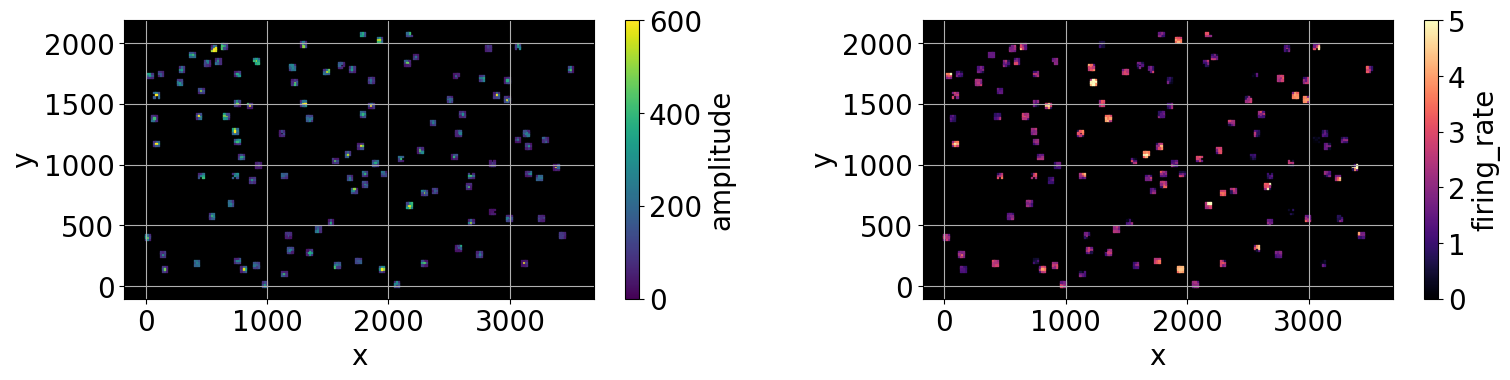

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# mean amplitude
df_stat.plot.scatter(ax=ax1, x='x', y='y', marker='s', s=1, c='amplitude', cmap='viridis', vmin=0.0, vmax=600.0)
ax1.set_aspect('equal')
ax1.set_facecolor('k')
ax1.grid()

# mean firing rate
df_stat.plot.scatter(ax=ax2, x='x', y='y', marker='s', s=1, c='firing_rate', cmap='magma', vmin=0.0, vmax=5.0)
ax2.set_aspect('equal')
ax2.set_facecolor('k')
ax2.grid()

plt.tight_layout()
plt.show()

上では見づらいので，一部を拡大してみよう．ついでにchannel idもアノテーションしておく．

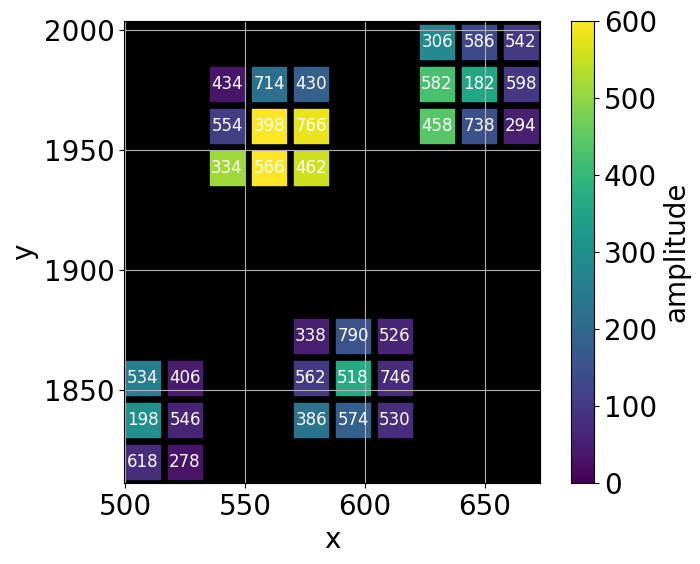

In [101]:
fig, ax = plt.subplots(figsize=(8, 6))

df_ = df_stat.query('500 < x < 800 and 1800 < y < 2000')
df_.plot.scatter(ax=ax, x='x', y='y', marker='s', s=600, c='amplitude', cmap='viridis', vmin=0.0, vmax=600.0)

for index, row in df_.iterrows():
    ax.annotate(text=str(index), xy=(row.x, row.y), fontsize=12, color='w', ha='center', va='center')
    
ax.set_aspect('equal')
ax.set_facecolor('k')    
ax.grid()

plt.locator_params(axis='y', nbins=4)
plt.show() 